# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:12<00:00, 4.93KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


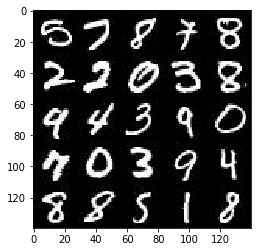

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

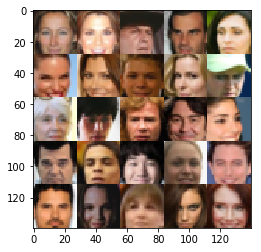

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs=tf.placeholder(shape=(None,image_width,image_height,image_channels),dtype=tf.float32)
    z=tf.placeholder(shape=(None,z_dim),dtype=tf.float32)
    learning_rate=tf.placeholder(dtype=tf.float32)
    return inputs,z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        alpha=0.2
        
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
        return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim,is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse=not is_train
    
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=reuse):
        alpha=0.2
        x1 = tf.layers.dense(z, units=7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
       
        # Output layer
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [40]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    smooth=0.2
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [41]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [42]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [43]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # TODO: Build Model
    input_real, input_z,l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z,data_shape[3])
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                batch_images*=2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z,l_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images,l_rate:learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 32, input_z, data_shape[3], data_image_mode)
                    

        

   
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7895... Generator Loss: 6.9176
Epoch 1/2... Discriminator Loss: 0.9882... Generator Loss: 19.0434
Epoch 1/2... Discriminator Loss: 0.5192... Generator Loss: 6.8055
Epoch 1/2... Discriminator Loss: 0.9956... Generator Loss: 10.6891
Epoch 1/2... Discriminator Loss: 3.8453... Generator Loss: 0.3100
Epoch 1/2... Discriminator Loss: 0.7940... Generator Loss: 1.7658
Epoch 1/2... Discriminator Loss: 0.8875... Generator Loss: 1.7020
Epoch 1/2... Discriminator Loss: 0.6345... Generator Loss: 2.9154
Epoch 1/2... Discriminator Loss: 0.5600... Generator Loss: 4.7531
Epoch 1/2... Discriminator Loss: 0.7916... Generator Loss: 2.0312


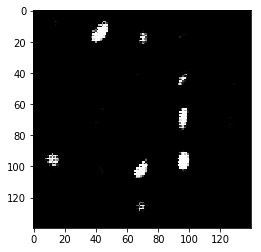

Epoch 1/2... Discriminator Loss: 1.1906... Generator Loss: 0.8920
Epoch 1/2... Discriminator Loss: 0.6797... Generator Loss: 2.8013
Epoch 1/2... Discriminator Loss: 0.8728... Generator Loss: 1.5194
Epoch 1/2... Discriminator Loss: 1.2562... Generator Loss: 1.8636
Epoch 1/2... Discriminator Loss: 0.9455... Generator Loss: 1.9458
Epoch 1/2... Discriminator Loss: 1.1256... Generator Loss: 1.1810
Epoch 1/2... Discriminator Loss: 0.9668... Generator Loss: 1.3631
Epoch 1/2... Discriminator Loss: 1.5052... Generator Loss: 2.9721
Epoch 1/2... Discriminator Loss: 1.0249... Generator Loss: 1.1812
Epoch 1/2... Discriminator Loss: 0.9818... Generator Loss: 2.0051


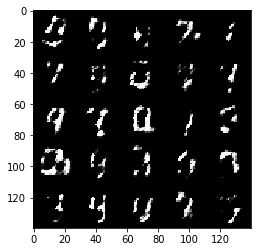

Epoch 1/2... Discriminator Loss: 0.8817... Generator Loss: 1.8094
Epoch 1/2... Discriminator Loss: 0.8325... Generator Loss: 1.8151
Epoch 1/2... Discriminator Loss: 1.1214... Generator Loss: 0.9654
Epoch 1/2... Discriminator Loss: 0.9625... Generator Loss: 1.2702
Epoch 1/2... Discriminator Loss: 0.8952... Generator Loss: 1.3972
Epoch 1/2... Discriminator Loss: 1.2100... Generator Loss: 0.7869
Epoch 1/2... Discriminator Loss: 0.9367... Generator Loss: 2.0896
Epoch 1/2... Discriminator Loss: 1.1513... Generator Loss: 1.5078
Epoch 1/2... Discriminator Loss: 1.2929... Generator Loss: 0.8014
Epoch 1/2... Discriminator Loss: 1.4820... Generator Loss: 0.5551


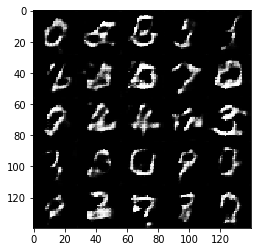

Epoch 1/2... Discriminator Loss: 1.6026... Generator Loss: 0.4898
Epoch 1/2... Discriminator Loss: 1.3535... Generator Loss: 0.6719
Epoch 1/2... Discriminator Loss: 1.3784... Generator Loss: 0.6500
Epoch 1/2... Discriminator Loss: 1.2486... Generator Loss: 0.9660
Epoch 1/2... Discriminator Loss: 1.2306... Generator Loss: 1.5748
Epoch 1/2... Discriminator Loss: 1.3345... Generator Loss: 1.7914
Epoch 1/2... Discriminator Loss: 1.2387... Generator Loss: 0.9813
Epoch 1/2... Discriminator Loss: 1.2174... Generator Loss: 0.8021
Epoch 1/2... Discriminator Loss: 1.2474... Generator Loss: 1.0365
Epoch 1/2... Discriminator Loss: 1.1867... Generator Loss: 0.8697


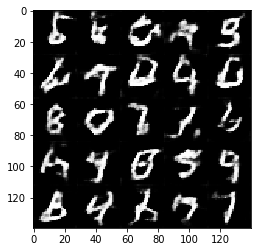

Epoch 1/2... Discriminator Loss: 1.1282... Generator Loss: 1.2280
Epoch 1/2... Discriminator Loss: 1.3557... Generator Loss: 2.2466
Epoch 1/2... Discriminator Loss: 1.2177... Generator Loss: 1.8926
Epoch 1/2... Discriminator Loss: 1.2100... Generator Loss: 0.9761
Epoch 1/2... Discriminator Loss: 1.1341... Generator Loss: 1.4692
Epoch 1/2... Discriminator Loss: 1.0930... Generator Loss: 1.3678
Epoch 1/2... Discriminator Loss: 1.2804... Generator Loss: 1.8214
Epoch 1/2... Discriminator Loss: 1.1713... Generator Loss: 1.0471
Epoch 1/2... Discriminator Loss: 1.6349... Generator Loss: 0.4784
Epoch 1/2... Discriminator Loss: 1.1623... Generator Loss: 1.0137


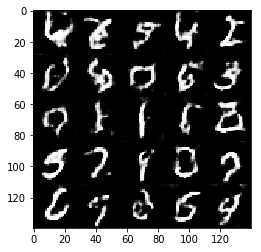

Epoch 1/2... Discriminator Loss: 1.6717... Generator Loss: 0.4791
Epoch 1/2... Discriminator Loss: 1.1364... Generator Loss: 1.4517
Epoch 1/2... Discriminator Loss: 1.3502... Generator Loss: 0.6764
Epoch 1/2... Discriminator Loss: 1.2700... Generator Loss: 0.8584
Epoch 1/2... Discriminator Loss: 1.2844... Generator Loss: 0.8217
Epoch 1/2... Discriminator Loss: 0.9985... Generator Loss: 1.7188
Epoch 1/2... Discriminator Loss: 1.4468... Generator Loss: 0.6410
Epoch 1/2... Discriminator Loss: 1.3707... Generator Loss: 0.6657
Epoch 1/2... Discriminator Loss: 1.0509... Generator Loss: 1.1253
Epoch 1/2... Discriminator Loss: 1.0683... Generator Loss: 1.1593


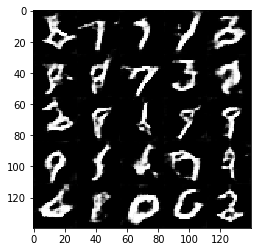

Epoch 1/2... Discriminator Loss: 1.3279... Generator Loss: 0.7089
Epoch 1/2... Discriminator Loss: 1.1646... Generator Loss: 1.6070
Epoch 1/2... Discriminator Loss: 1.1933... Generator Loss: 1.8727
Epoch 1/2... Discriminator Loss: 1.1480... Generator Loss: 1.0563
Epoch 1/2... Discriminator Loss: 1.2197... Generator Loss: 0.8508
Epoch 1/2... Discriminator Loss: 1.1220... Generator Loss: 1.0816
Epoch 1/2... Discriminator Loss: 1.1728... Generator Loss: 0.9504
Epoch 1/2... Discriminator Loss: 1.2528... Generator Loss: 1.2496
Epoch 1/2... Discriminator Loss: 1.0468... Generator Loss: 1.0962
Epoch 1/2... Discriminator Loss: 1.1211... Generator Loss: 1.1534


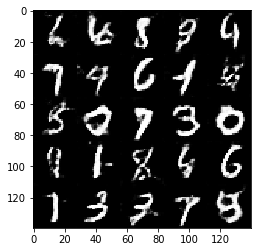

Epoch 1/2... Discriminator Loss: 1.0700... Generator Loss: 1.3823
Epoch 1/2... Discriminator Loss: 1.1356... Generator Loss: 1.2024
Epoch 1/2... Discriminator Loss: 1.4530... Generator Loss: 0.6084
Epoch 1/2... Discriminator Loss: 1.0899... Generator Loss: 1.0552
Epoch 1/2... Discriminator Loss: 1.1260... Generator Loss: 1.0498
Epoch 1/2... Discriminator Loss: 2.2667... Generator Loss: 0.2758
Epoch 1/2... Discriminator Loss: 1.1447... Generator Loss: 0.9487
Epoch 1/2... Discriminator Loss: 1.1546... Generator Loss: 1.0405
Epoch 1/2... Discriminator Loss: 1.0657... Generator Loss: 1.4621
Epoch 1/2... Discriminator Loss: 1.0299... Generator Loss: 1.3859


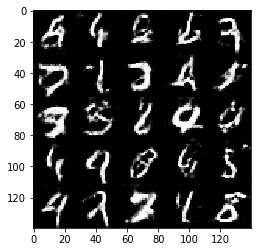

Epoch 1/2... Discriminator Loss: 1.9066... Generator Loss: 2.8072
Epoch 1/2... Discriminator Loss: 1.1447... Generator Loss: 1.1296
Epoch 1/2... Discriminator Loss: 1.0326... Generator Loss: 1.1416
Epoch 1/2... Discriminator Loss: 1.1720... Generator Loss: 0.8929
Epoch 1/2... Discriminator Loss: 1.0235... Generator Loss: 1.7882
Epoch 1/2... Discriminator Loss: 1.0665... Generator Loss: 1.0607
Epoch 1/2... Discriminator Loss: 1.2823... Generator Loss: 1.9815
Epoch 1/2... Discriminator Loss: 1.1097... Generator Loss: 1.0259
Epoch 1/2... Discriminator Loss: 1.0523... Generator Loss: 1.8422
Epoch 1/2... Discriminator Loss: 1.1424... Generator Loss: 0.8668


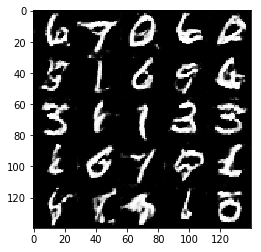

Epoch 1/2... Discriminator Loss: 1.2033... Generator Loss: 0.8505
Epoch 1/2... Discriminator Loss: 1.8486... Generator Loss: 2.6547
Epoch 1/2... Discriminator Loss: 1.0229... Generator Loss: 1.2240
Epoch 2/2... Discriminator Loss: 1.1468... Generator Loss: 0.8766
Epoch 2/2... Discriminator Loss: 1.5961... Generator Loss: 0.5438
Epoch 2/2... Discriminator Loss: 1.2289... Generator Loss: 0.8381
Epoch 2/2... Discriminator Loss: 1.1355... Generator Loss: 1.7654
Epoch 2/2... Discriminator Loss: 1.0574... Generator Loss: 1.3113
Epoch 2/2... Discriminator Loss: 1.0446... Generator Loss: 1.3148
Epoch 2/2... Discriminator Loss: 1.1990... Generator Loss: 1.0273


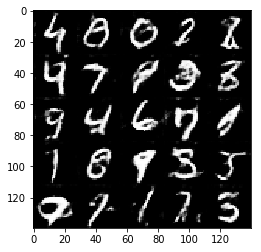

Epoch 2/2... Discriminator Loss: 1.3683... Generator Loss: 0.6253
Epoch 2/2... Discriminator Loss: 1.1589... Generator Loss: 0.8696
Epoch 2/2... Discriminator Loss: 1.2779... Generator Loss: 0.8499
Epoch 2/2... Discriminator Loss: 1.2370... Generator Loss: 1.5906
Epoch 2/2... Discriminator Loss: 1.1046... Generator Loss: 0.9545
Epoch 2/2... Discriminator Loss: 1.0834... Generator Loss: 1.6309
Epoch 2/2... Discriminator Loss: 1.0830... Generator Loss: 1.6022
Epoch 2/2... Discriminator Loss: 1.0044... Generator Loss: 1.9144
Epoch 2/2... Discriminator Loss: 1.5255... Generator Loss: 0.5815
Epoch 2/2... Discriminator Loss: 1.2921... Generator Loss: 0.7581


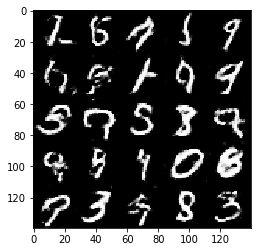

Epoch 2/2... Discriminator Loss: 1.2502... Generator Loss: 0.7930
Epoch 2/2... Discriminator Loss: 1.2835... Generator Loss: 0.7618
Epoch 2/2... Discriminator Loss: 1.0527... Generator Loss: 1.4152
Epoch 2/2... Discriminator Loss: 1.1766... Generator Loss: 1.0619
Epoch 2/2... Discriminator Loss: 1.1425... Generator Loss: 1.2386
Epoch 2/2... Discriminator Loss: 1.1840... Generator Loss: 0.8250
Epoch 2/2... Discriminator Loss: 1.1731... Generator Loss: 0.9322
Epoch 2/2... Discriminator Loss: 1.3547... Generator Loss: 0.6965
Epoch 2/2... Discriminator Loss: 1.0594... Generator Loss: 1.1955
Epoch 2/2... Discriminator Loss: 1.2223... Generator Loss: 0.8913


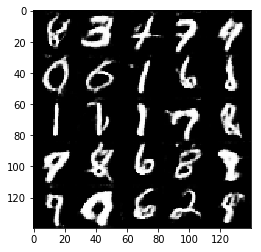

Epoch 2/2... Discriminator Loss: 1.1238... Generator Loss: 1.1349
Epoch 2/2... Discriminator Loss: 1.0085... Generator Loss: 1.1791
Epoch 2/2... Discriminator Loss: 1.2816... Generator Loss: 0.7628
Epoch 2/2... Discriminator Loss: 1.2197... Generator Loss: 0.8319
Epoch 2/2... Discriminator Loss: 1.0969... Generator Loss: 1.0779
Epoch 2/2... Discriminator Loss: 1.1972... Generator Loss: 0.8546
Epoch 2/2... Discriminator Loss: 1.2535... Generator Loss: 0.7980
Epoch 2/2... Discriminator Loss: 1.0494... Generator Loss: 1.4988
Epoch 2/2... Discriminator Loss: 0.9121... Generator Loss: 1.3533
Epoch 2/2... Discriminator Loss: 1.1562... Generator Loss: 1.0849


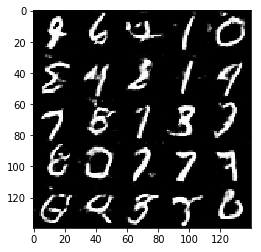

Epoch 2/2... Discriminator Loss: 1.1310... Generator Loss: 0.9569
Epoch 2/2... Discriminator Loss: 1.1406... Generator Loss: 0.9710
Epoch 2/2... Discriminator Loss: 1.0742... Generator Loss: 1.6776
Epoch 2/2... Discriminator Loss: 1.1507... Generator Loss: 0.8807
Epoch 2/2... Discriminator Loss: 1.1137... Generator Loss: 1.6371
Epoch 2/2... Discriminator Loss: 0.9207... Generator Loss: 1.4132
Epoch 2/2... Discriminator Loss: 1.5832... Generator Loss: 0.5739
Epoch 2/2... Discriminator Loss: 1.0840... Generator Loss: 1.6123
Epoch 2/2... Discriminator Loss: 1.0221... Generator Loss: 1.0760
Epoch 2/2... Discriminator Loss: 1.2876... Generator Loss: 0.7345


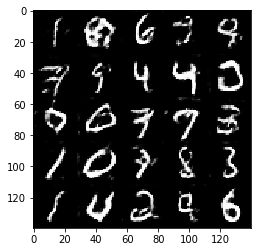

Epoch 2/2... Discriminator Loss: 1.1887... Generator Loss: 0.8795
Epoch 2/2... Discriminator Loss: 1.0565... Generator Loss: 1.7947
Epoch 2/2... Discriminator Loss: 1.1343... Generator Loss: 0.8616
Epoch 2/2... Discriminator Loss: 1.1552... Generator Loss: 0.8809
Epoch 2/2... Discriminator Loss: 1.1417... Generator Loss: 0.9174
Epoch 2/2... Discriminator Loss: 1.0170... Generator Loss: 1.1133
Epoch 2/2... Discriminator Loss: 0.9533... Generator Loss: 1.7180
Epoch 2/2... Discriminator Loss: 1.0592... Generator Loss: 1.0364
Epoch 2/2... Discriminator Loss: 1.1292... Generator Loss: 2.0490
Epoch 2/2... Discriminator Loss: 0.9525... Generator Loss: 1.3893


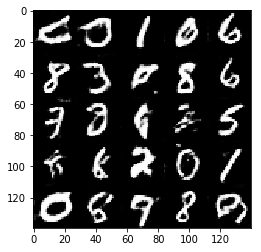

Epoch 2/2... Discriminator Loss: 0.9213... Generator Loss: 1.6287
Epoch 2/2... Discriminator Loss: 1.0321... Generator Loss: 1.1930
Epoch 2/2... Discriminator Loss: 0.9461... Generator Loss: 1.8668
Epoch 2/2... Discriminator Loss: 0.9682... Generator Loss: 2.0561
Epoch 2/2... Discriminator Loss: 1.1129... Generator Loss: 0.9618
Epoch 2/2... Discriminator Loss: 0.8593... Generator Loss: 1.4247
Epoch 2/2... Discriminator Loss: 0.8722... Generator Loss: 1.3627
Epoch 2/2... Discriminator Loss: 1.6238... Generator Loss: 0.5536
Epoch 2/2... Discriminator Loss: 1.0413... Generator Loss: 2.3110
Epoch 2/2... Discriminator Loss: 1.2063... Generator Loss: 0.8430


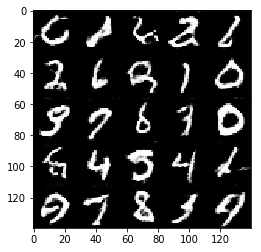

Epoch 2/2... Discriminator Loss: 1.1602... Generator Loss: 2.8066
Epoch 2/2... Discriminator Loss: 1.2307... Generator Loss: 0.9089
Epoch 2/2... Discriminator Loss: 1.4476... Generator Loss: 0.7413
Epoch 2/2... Discriminator Loss: 0.9427... Generator Loss: 1.8112
Epoch 2/2... Discriminator Loss: 0.8170... Generator Loss: 1.8477
Epoch 2/2... Discriminator Loss: 1.4232... Generator Loss: 0.7608
Epoch 2/2... Discriminator Loss: 1.0150... Generator Loss: 1.2798
Epoch 2/2... Discriminator Loss: 1.2289... Generator Loss: 0.9003
Epoch 2/2... Discriminator Loss: 1.0397... Generator Loss: 1.6835
Epoch 2/2... Discriminator Loss: 0.9827... Generator Loss: 1.8750


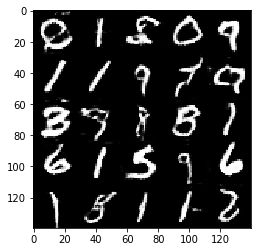

Epoch 2/2... Discriminator Loss: 0.9979... Generator Loss: 2.0706
Epoch 2/2... Discriminator Loss: 0.8582... Generator Loss: 1.9920
Epoch 2/2... Discriminator Loss: 1.1839... Generator Loss: 0.8838
Epoch 2/2... Discriminator Loss: 1.0217... Generator Loss: 1.1549
Epoch 2/2... Discriminator Loss: 1.0803... Generator Loss: 0.9757
Epoch 2/2... Discriminator Loss: 1.0097... Generator Loss: 2.3145
Epoch 2/2... Discriminator Loss: 1.0532... Generator Loss: 1.6346
Epoch 2/2... Discriminator Loss: 1.3264... Generator Loss: 0.8099
Epoch 2/2... Discriminator Loss: 0.8928... Generator Loss: 1.5285
Epoch 2/2... Discriminator Loss: 0.9519... Generator Loss: 1.7772


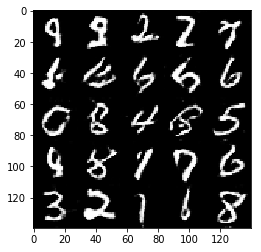

Epoch 2/2... Discriminator Loss: 0.7682... Generator Loss: 2.0160
Epoch 2/2... Discriminator Loss: 0.7451... Generator Loss: 1.9096
Epoch 2/2... Discriminator Loss: 1.4078... Generator Loss: 1.0286
Epoch 2/2... Discriminator Loss: 0.9473... Generator Loss: 1.3722
Epoch 2/2... Discriminator Loss: 0.8888... Generator Loss: 1.4406
Epoch 2/2... Discriminator Loss: 0.9489... Generator Loss: 1.2332
Epoch 2/2... Discriminator Loss: 1.5223... Generator Loss: 0.7139


In [44]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.8861... Generator Loss: 1.9811
Epoch 1/1... Discriminator Loss: 0.7765... Generator Loss: 2.4840
Epoch 1/1... Discriminator Loss: 0.7019... Generator Loss: 4.8271
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 2.3679
Epoch 1/1... Discriminator Loss: 0.7559... Generator Loss: 3.8199
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 0.9502
Epoch 1/1... Discriminator Loss: 1.5456... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 0.7870... Generator Loss: 1.9180
Epoch 1/1... Discriminator Loss: 0.6373... Generator Loss: 3.5299
Epoch 1/1... Discriminator Loss: 0.6340... Generator Loss: 2.4902


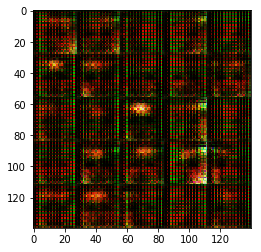

Epoch 1/1... Discriminator Loss: 0.5518... Generator Loss: 4.7212
Epoch 1/1... Discriminator Loss: 0.6560... Generator Loss: 4.1065
Epoch 1/1... Discriminator Loss: 0.7968... Generator Loss: 1.9959
Epoch 1/1... Discriminator Loss: 3.8773... Generator Loss: 7.7413
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.9771
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.6906


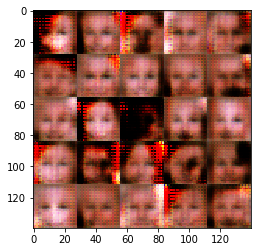

Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 1.1502
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 1.0164
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 1.2362
Epoch 1/1... Discriminator Loss: 1.6355... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 1.0538
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 1.7358


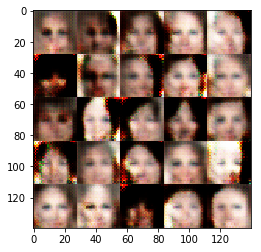

Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 1.3831
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 1.0094
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 1.3473
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 1.2154
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 1.9587
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 1.2651
Epoch 1/1... Discriminator Loss: 2.1042... Generator Loss: 2.9869
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 1.2820
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 1.6626


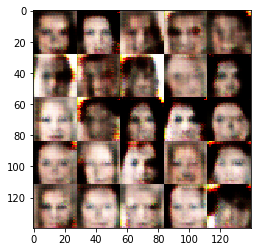

Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 1.4442
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 1.4248
Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 1.0832
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 1.0065
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 1.0794
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 1.4466
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 1.2270


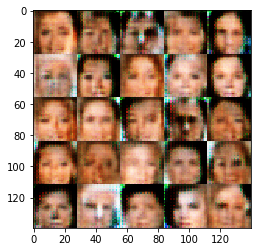

Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 1.0525
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.9302
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 1.8201
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.9051
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 1.0841
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.8980
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.9100


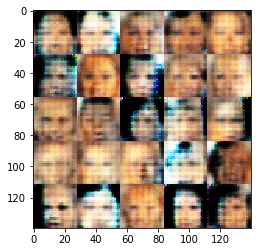

Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.9527
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 1.3225
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 1.0533
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 1.6376


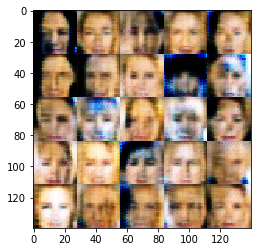

Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.5799
Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 1.6223
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 1.0721
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.8942


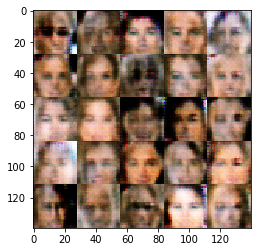

Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 1.4282
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 1.0782
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 1.0516
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 1.0929
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.9533
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.9978


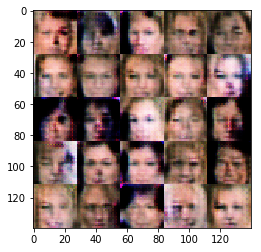

Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 1.5264
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 1.5362
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 1.2017
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 1.0632
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.8723


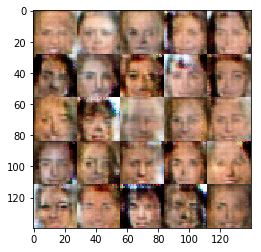

Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 1.3753
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 1.9855
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 1.0850


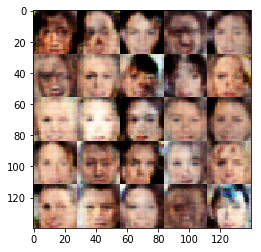

Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.8894
Epoch 1/1... Discriminator Loss: 0.7521... Generator Loss: 1.6285
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.9878
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 1.1127
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 1.3055
Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.9333
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.9420


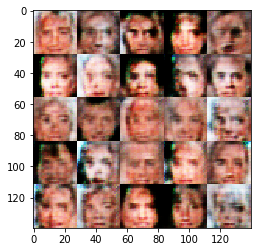

Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.9905
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 1.8723
Epoch 1/1... Discriminator Loss: 1.9460... Generator Loss: 0.3281
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 1.2577
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 1.1037
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 1.0271


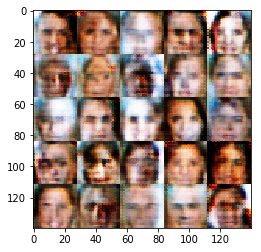

Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 1.2591
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.9330
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 1.0023
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 1.1822


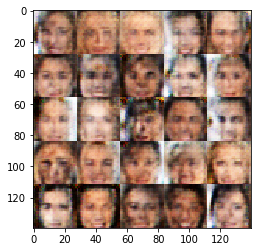

Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.9655
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.9084


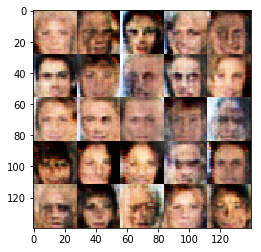

Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.9413
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 1.1758
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 1.1745
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.9235
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 1.1187
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 1.0471
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.9249


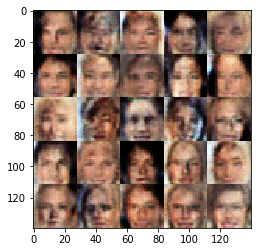

Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 1.0213
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 1.0725
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 1.0296
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.9222
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.8762


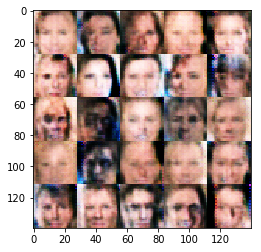

Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 1.2147
Epoch 1/1... Discriminator Loss: 1.7323... Generator Loss: 2.1449
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 1.0218
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 1.0935
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.8951
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.8521


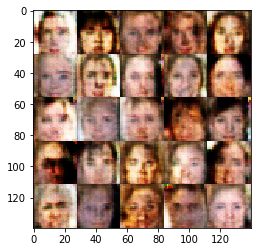

Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 1.0206
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.9765
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.9703
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 1.0225
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.8733


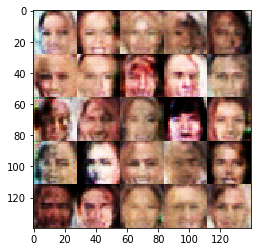

Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 1.4772
Epoch 1/1... Discriminator Loss: 1.5139... Generator Loss: 1.4845
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 1.0096


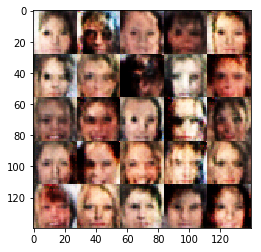

Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.8980
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 1.1071
Epoch 1/1... Discriminator Loss: 1.5540... Generator Loss: 1.6517
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 1.0229
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 1.3434


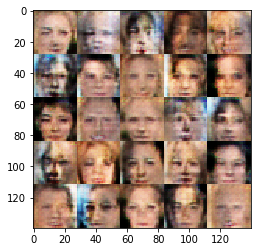

Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 1.0419
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.9512


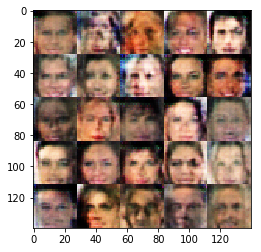

Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 1.2853
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.9369
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 1.2269
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 1.1798


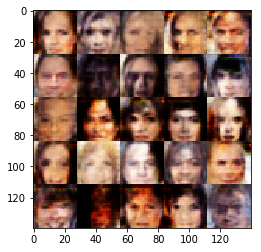

In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.